### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.feature_selection import RFE

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

2024-11-18 08:19:37.197361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 08:19:37.715525: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 08:19:38.196010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731928778.495984    1044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731928778.597319    1044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 08:19:39.502077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [91]:
df_train = pd.read_csv("./dataset/treinamento.csv")
df_test = pd.read_csv("./dataset/teste.csv")

In [92]:
df_train = df_train.drop(columns=['DIAS_ULTIMA_EMISSAO', 'VALOR_INICIAL'])
df_test = df_test.drop(columns=['DIAS_ULTIMA_EMISSAO', 'VALOR_INICIAL'])

In [93]:
y = df_train['INADIPLENCIA']
df_train.drop(columns=['INADIPLENCIA'], inplace=True)

### Pré-processamento

In [69]:
scaler = MinMaxScaler()
df_train = pd.DataFrame(data=scaler.fit_transform(df_train), columns=df_train.columns)
df_train

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF,PORTE,SEGMENTO_INDUSTRIAL_Comércio,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,PRAZO_PAGAMENTO,RENDA_FUNCIONARIO,RENDA_MEDIA,RENDA_STD,PERCENTUAL_A_PAGAR,Quantidade_Emprestimo
0,0.022867,0.142857,0.144587,0.555556,0.0,0.333333,1.0,0.0,0.0,0.006353,0.009197,0.280858,0.307895,0.010446,0.000000
1,0.003408,0.142857,0.151971,0.454545,0.0,0.666667,0.0,0.0,0.0,0.008595,0.011815,0.334980,0.286951,0.001305,0.000000
2,0.008142,0.000000,0.176153,0.515152,0.0,1.000000,1.0,0.0,0.0,0.011211,0.012083,0.334727,0.364696,0.003121,0.000000
3,0.002388,0.571429,0.229813,0.686869,0.0,1.000000,0.0,1.0,0.0,0.005979,0.011822,0.439984,0.467526,0.000697,0.000000
4,0.018101,0.142857,0.123778,0.530303,0.0,1.000000,1.0,0.0,0.0,0.005979,0.008248,0.330538,0.398149,0.007027,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77409,0.004740,0.142857,0.150691,0.535354,0.0,0.666667,0.0,1.0,0.0,0.005605,0.009947,0.307282,0.188853,0.001979,0.071304
77410,0.005760,0.285714,0.041995,0.752525,0.0,0.666667,0.0,0.0,1.0,0.005605,0.001971,0.308908,0.387697,0.002393,0.089565
77411,0.010539,0.285714,0.129199,0.722222,0.0,0.666667,1.0,0.0,0.0,0.007100,0.006321,0.319005,0.268282,0.004239,0.074783
77412,0.001901,0.000000,0.083813,0.661616,0.0,0.666667,1.0,0.0,0.0,0.013079,0.004476,0.249015,0.317856,0.000980,0.120870


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=10)
len(X_train), len(X_test)

(61931, 15483)

In [7]:
sm = SMOTE(random_state=10)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)
len(X_train_balanced)

115202

### Treinamento

Como para cada modelo será usado o GridSearchCV, o dado de validação não é necessário, devido ao cross validation automático, separando internamente o dado de treino em dado de treino e teste.

Gridsearch com o random forest

In [20]:
params = {'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 3, 4], 'max_features': ['sqrt', 'log2', 0.5, 0.75], 'bootstrap': [True, False]}

model = RandomForestClassifier(n_estimators=500, random_state=10)

grid_search_rf = GridSearchCV(model, param_grid=params, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time= 1.6min


/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time= 1.6min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=4; total time= 1.6min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=4; total time= 1.6min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time= 1.7min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=4; total time= 1.7min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=6; total time= 1.6min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=6; total time= 1.5min
[CV] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time= 1.6min
[CV] END bootstrap=True, criterion=gini,

/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=1, min_samples_split=8; total time= 2.7min
[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=2, min_samples_split=6; total time= 2.7min
[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=3, min_samples_split=2; total time= 2.7min
[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=3, min_samples_split=6; total time= 2.7min
[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time= 2.6min
[CV] END bootstrap=False, criterion=log_loss, max_features=sqrt, min_samples_leaf=4, min_samples_split=8; total time= 2.6min
[CV] END bootstrap=False, criterion=log_loss, max_features=log2, min_samples_leaf=1, min_samples_split=6; total time= 2.7min
[CV] END bootstrap=False, criterion=log_loss, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time= 2.7min

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=10),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', 0.5, 0.75],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='f1_macro', verbose=2)

In [21]:
print(grid_search_rf.best_params_)
print("F1 score for Random Forest", grid_search_rf.best_score_)

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1 score for Random Forest 0.9748744719079682


In [22]:
y_pred = grid_search_rf.predict(X_test)

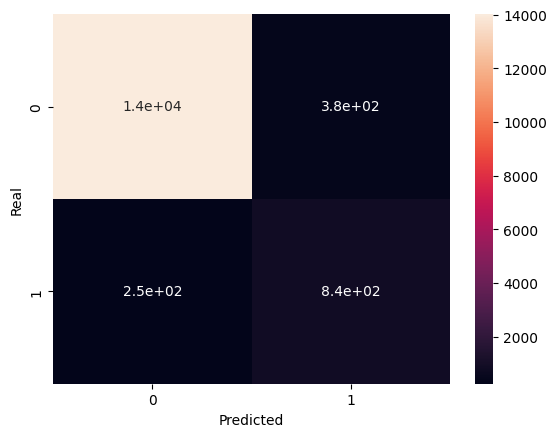

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Real");

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     14393
           1       0.69      0.77      0.73      1090

    accuracy                           0.96     15483
   macro avg       0.84      0.87      0.85     15483
weighted avg       0.96      0.96      0.96     15483



Gridsearch com o ada boost

In [8]:
params = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}

model = AdaBoostClassifier(n_estimators=400, random_state=10, estimator=DecisionTreeClassifier(max_depth=1))

grid_search_ada = GridSearchCV(model, param_grid=params, cv=5, scoring='f1_macro', verbose=3, n_jobs=-1)
grid_search_ada.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/daniel/miniconda3/envs/datarisk/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          n_estimators=400, random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75,
                                           1]},
             scoring='f1_macro', verbose=3)

In [9]:
print(grid_search_ada.best_params_)
print("F1 score for Ada Boost", grid_search_ada.best_score_)

{'learning_rate': 1}
F1 score for Ada Boost 0.8676719643607594


In [10]:
y_pred = grid_search_ada.predict(X_test)

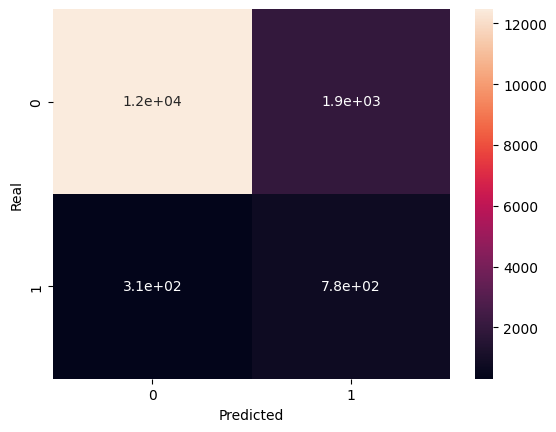

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Real");

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     14393
           1       0.29      0.72      0.41      1090

    accuracy                           0.86     15483
   macro avg       0.63      0.79      0.66     15483
weighted avg       0.93      0.86      0.88     15483



Gridsearch com o XGBoost

In [15]:
params = {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5], 'max_depth': [6, 8, 10, 12, 14, 15, 16], 'min_child_weight': [1, 2, 3, 4]}

model = XGBClassifier(n_estimators=400, random_state=10)

grid_search_xgb = GridSearchCV(model, param_grid=params, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=400,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=10, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5],
                         'max_depth': [6, 8, 10, 12, 14, 15, 16],
                         'min_child_weight': [1, 2, 3, 4]},
             scoring='f1_macro', verbose=1)

In [16]:
print(grid_search_xgb.best_params_)
print("F1 score for XGB", grid_search_xgb.best_score_) #0.6731139970469258

{'learning_rate': 0.2, 'max_depth': 14, 'min_child_weight': 1}
F1 score for XGB 0.9748736020628315


In [17]:
y_pred = grid_search_xgb.predict(X_test)

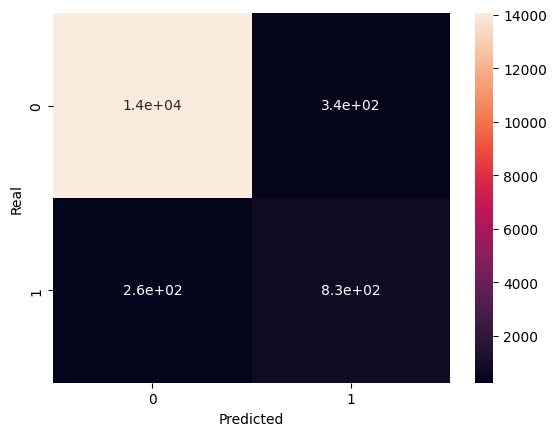

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Real");

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14393
           1       0.71      0.76      0.74      1090

    accuracy                           0.96     15483
   macro avg       0.85      0.87      0.86     15483
weighted avg       0.96      0.96      0.96     15483



RNA

In [25]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


W0000 00:00:1731975118.328113    1044 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [40]:
model = models.Sequential()
model.add(layers.Input(shape=(15,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)

model.summary()
model.compile(loss="binary_crossentropy", optimizer=optimizer)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,497 (681.63 KB)

 Trainable params: 174,497 (681.63 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=10)
len(X_train), len(X_val)

(92161, 23041)

In [42]:
epochs=300
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True)]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=callbacks)

Epoch 1/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5915 - val_loss: 0.4885 - learning_rate: 0.0010
Epoch 2/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4945 - val_loss: 0.4443 - learning_rate: 0.0010
Epoch 3/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4550 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 4/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4325 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 5/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4137 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 6/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3919 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 7/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3793 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 8/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3688 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 9/300
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3515 - val_loss: 0.3221 - learn

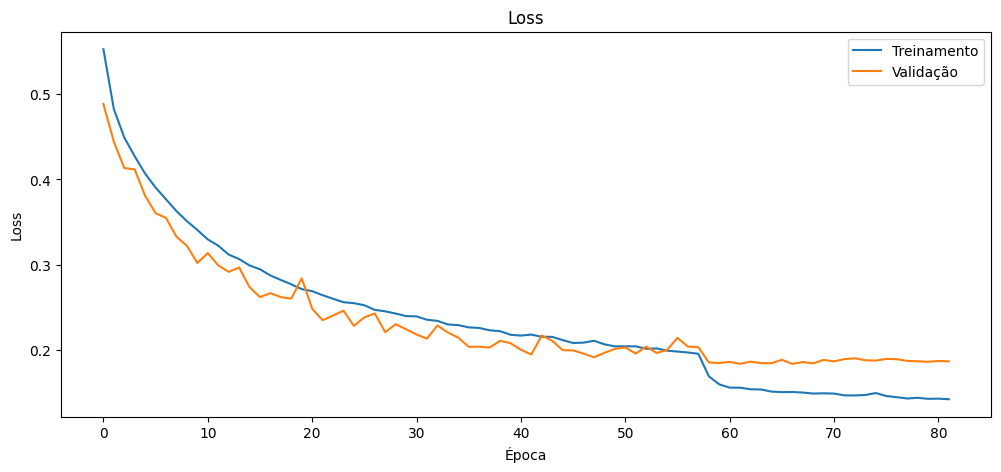

In [43]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [44]:
y_pred = [1 if pred >= 0.5 else 0 for pred in model.predict(X_test)]

484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step


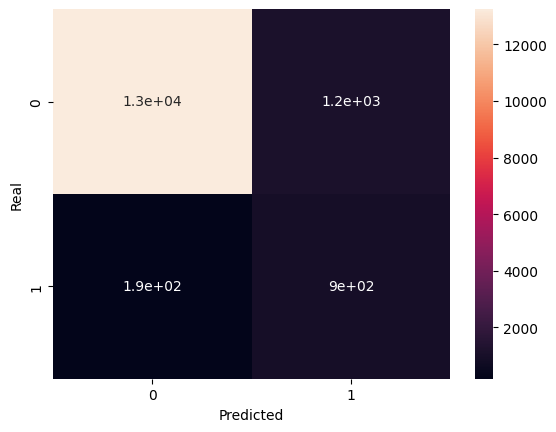

In [45]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted")
plt.ylabel("Real");

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     14393
           1       0.44      0.83      0.58      1090

    accuracy                           0.91     15483
   macro avg       0.71      0.87      0.76     15483
weighted avg       0.95      0.91      0.93     15483



### Predição dado de teste

In [94]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('model', XGBClassifier(n_estimators=400, learning_rate=0.2, max_depth=14, min_child_weight=1, random_state=10))
])

In [95]:
output_df = df_test[["ID_CLIENTE", "SAFRA_REF"]]
df_test.drop(columns=["ID_CLIENTE", "SAFRA_REF"], inplace=True)
df_test = df_test[df_train.columns]
df_test

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF,PORTE,SEGMENTO_INDUSTRIAL_Comércio,SEGMENTO_INDUSTRIAL_Indústria,SEGMENTO_INDUSTRIAL_Serviços,PRAZO_PAGAMENTO,RENDA_FUNCIONARIO,RENDA_MEDIA,RENDA_STD,PERCENTUAL_A_PAGAR,Quantidade_Emprestimo
0,91012.70,6.99,305035.0,141.0,0,2.0,0.0,0.0,1.0,18,2163.368794,272717.200000,165661.538101,0.333726,139
1,28067.60,5.99,385397.0,142.0,0,0.0,1.0,0.0,0.0,18,2714.063380,293850.571429,204946.212816,0.095517,1056
2,7155.82,6.99,513088.0,111.0,0,2.0,0.0,0.0,1.0,25,4622.414414,208321.428571,118619.100684,0.034350,54
3,35455.07,5.99,244944.0,100.0,0,2.0,1.0,0.0,0.0,18,2449.440000,226334.000000,0.000000,0.156649,5
4,47173.99,5.99,98492.0,118.0,0,3.0,1.0,0.0,0.0,22,834.677966,292821.093750,272886.057839,0.161102,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12270,122875.35,8.99,311422.0,150.0,0,1.0,0.0,0.0,1.0,18,2076.146667,288411.333333,227195.909138,0.426042,86
12271,24005.50,11.99,269274.0,124.0,0,2.0,0.0,0.0,1.0,19,2171.564516,182380.052632,166876.282334,0.131623,67
12272,302200.00,5.99,229034.0,109.0,0,2.0,0.0,1.0,0.0,2500,2101.229358,271745.030303,140802.789766,1.112072,74
12273,143791.85,5.99,220341.0,122.0,0,2.0,0.0,0.0,1.0,17,1806.073770,243740.000000,172876.094535,0.589939,82


In [96]:
df_train_balanced, y_train_balanced = sm.fit_resample(df_train, y)
pipeline.fit(df_train_balanced, y_train_balanced)
y_pred = pipeline.predict_proba(df_test)

In [97]:
output_df['INADIMPLENTE'] = y_pred[:, 1]
output_df

,ID_CLIENTE,SAFRA_REF,INADIMPLENTE
0,6987942592445950913,2021-07,0.000055
1,5761480994209806499,2021-07,0.000015
2,8163895533020293251,2021-07,0.843281
3,113538242419211987,2021-07,0.000118
4,1616952665234409442,2021-07,0.001521
...,...,...,...
12270,4993499380140734678,2021-11,0.000093
12271,6486277549325701534,2021-11,0.007977
12272,4614484019183480654,2021-11,0.004006
12273,1299146298565441811,2021-11,0.000473


In [98]:
output_df.to_csv("output.csv")